In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys, os
import numpy as np

WORK_PATH = "./"
SOURCE_PATH = os.path.join(WORK_PATH, "src")
sys.path.append(SOURCE_PATH)
EXPORT_PATH = os.path.join(WORK_PATH, "export")
DATA_PATH = os.path.join("..", "data")

In [4]:
from graphnics import FenicsGraph, TubeFile

/home/pierce/Software/environments/cmor_mdanderson/lib/python3.12/site-packages/block/__init__.py:15: UserWarning: The cbc.block repository has moved to https://github.com/blocknics/cbc.block
  warnings.warn('The cbc.block repository has moved to https://github.com/blocknics/cbc.block', UserWarning)


Missing HsMG for fract norm computing


In [5]:
import tissue

TEST_NUM_NODES_EXP = 5

TEST_GRAPH = FenicsGraph()

TEST_GRAPH_NODES = {
    0: [0.000, 0.020, 0.015],
    1: [0.010, 0.020, 0.015],
    2: [0.022, 0.013, 0.015],
    3: [0.022, 0.028, 0.015],
    4: [0.015, 0.005, 0.015],
    5: [0.015, 0.035, 0.015],
    6: [0.038, 0.005, 0.015],
    7: [0.038, 0.035, 0.015]
}    
TEST_GRAPH_EDGES = [
    (0, 1, 0.004),
    (1, 2, 0.003),
    (1, 3, 0.003),
    (2, 4, 0.002),
    (2, 6, 0.003),
    (3, 5, 0.002),
    (3, 7, 0.003)
]

for node_id, pos in TEST_GRAPH_NODES.items():
    TEST_GRAPH.add_node(node_id, pos=pos)
    
for (u, v, radius) in TEST_GRAPH_EDGES:
    TEST_GRAPH.add_edge(u, v, radius=radius)

TEST_GRAPH.make_mesh(n = TEST_NUM_NODES_EXP)

TEST_GRAPH.make_submeshes()

TEST_OMEGA_BUILD = tissue.OmegaBuild(TEST_GRAPH, bounds = [[0,0,0],[0.05,0.04,0.03]])

X_ZERO_PLANE = tissue.AxisPlane(0, 0.0)

TEST_DOMAIN = tissue.DomainBuild(
    TEST_GRAPH,
    TEST_OMEGA_BUILD,
    Lambda_inlet_nodes = [0],
    Omega_sink_subdomain = X_ZERO_PLANE
)

In [6]:
import fem

TEST_CUBES = fem.SubCubes(
    domain = TEST_DOMAIN,
    gamma = 0.0,
    gamma_a = 1.0,
    gamma_R = 1.0e-6,
    mu = 1.0e-3,
    k_t = 1.0e-10,
    k_v = 1.0e-10,
    P_in = 100.0 * 133.322,
    P_cvp = 1.0 * 133.322,
    lower_cube_bounds = [[0.0,0.0,0.0],[0.01,0.01,0.01]],
    upper_cube_bounds = [[0.033, 0.03, 0.01],[0.043,0.04,0.02]]
)

Averaging over 224 cells: 100%|█████████████| 224/224 [00:00<00:00, 2294.84it/s]


/tmp/ipykernel_16904/185484515.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()


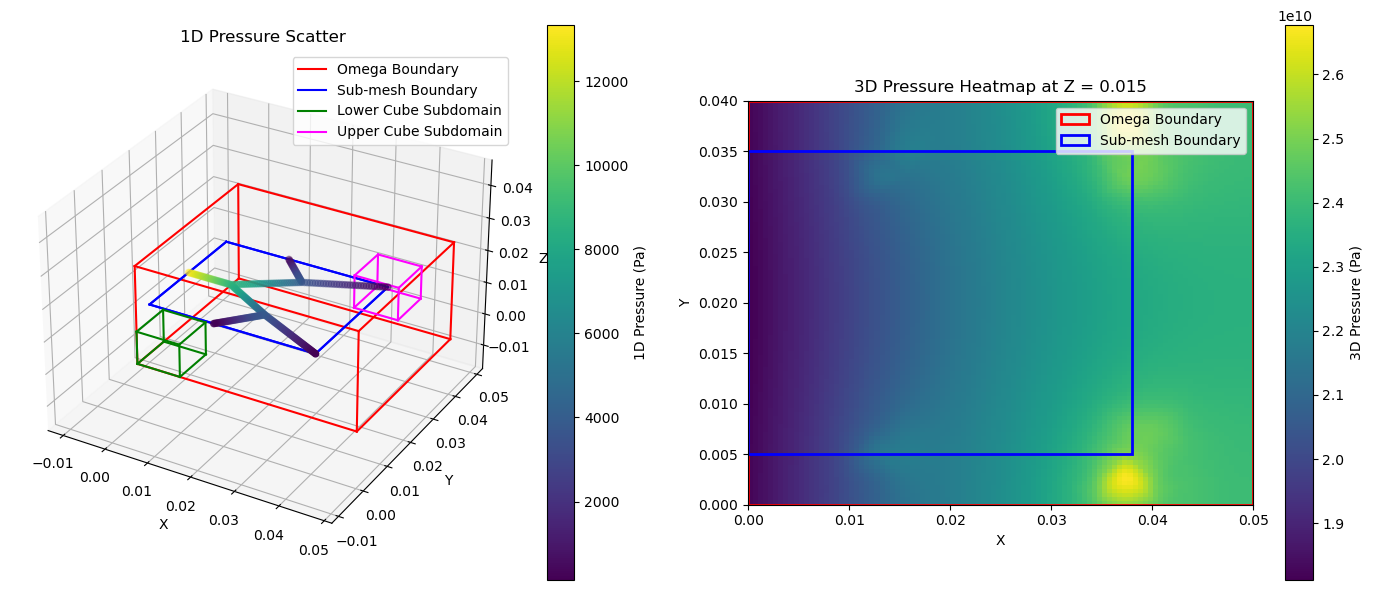

In [25]:
import visualize

cube_lower_bounds = TEST_CUBES.lower_cube_bounds
cube_upper_bounds = TEST_CUBES.upper_cube_bounds

fig1 = visualize.plot_with_boundaries(TEST_CUBES.uh1d, TEST_CUBES.uh3d,
     cube_lower=cube_lower_bounds,
     cube_upper=cube_upper_bounds)
fig1.show()

In [ ]:
import datetime
import pytz

cst = pytz.timezone("America/Chicago")
now = datetime.datetime.now(cst)
timestamp = now.strftime("%Y%m%d_%H%M")
filename = f"output_{timestamp}"

SAVE_PATH = os.path.join(WORK_PATH, "export", filename)
CUBES_TEST.save_vtk(SAVE_PATH)

In [ ]:
visualize.plot_with_boundaries_plotly(CUBES_TEST.uh1d, CUBES_TEST.uh3d,
     cube_lower=cube_lower_bounds,
     cube_upper=cube_upper_bounds)

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import datetime
import pytz
from IPython.display import Image, display  # Only needed for displaying images in notebooks

TEST_SWEEP_DEFAULT = {
    'domain': TEST_MEASURE,
    'gamma': 1.0e-6,  
    'gamma_R': 1.0e-7,
    'gamma_a': 1.0e-7,
    'mu': 1.0e-3,     
    'k_t': 1.0e-10,   
    'k_v': 1.0e-11,   
    'P_in': 100 * 133.322,
    'p_cvp': 1.0 * 133.322,
    'lower_cube_bounds': [[0.0, 0.0, 0.0], [0.01, 0.01, 0.01]],
    'upper_cube_bounds': [[0.033, 0.03, 0.01], [0.043, 0.04, 0.02]]
}

TEST_SWEEP_CONFIG = {
    'k_t': {
        'values': np.logspace(-18, -8, 50),
        'xlabel': "Tissue Permeability k_t",
        'title': "Cube Flux vs. Tissue Permeability k_t",
        'plot_type': 'semilogx',
        'grid_kwargs': {'which': "both", 'ls': "--"}
    },
    'gamma': {
        'values': np.logspace(-15, 3, 50),
        'xlabel': "Gamma",
        'title': "Cube Flux vs. Gamma",
        'plot_type': 'semilogx',
        'grid_kwargs': {'which': "both", 'ls': "--"}
    },
    'gamma_R': {
        'values': np.logspace(-15, 3, 50),
        'xlabel': "Gamma_R",
        'title': "Cube Flux vs. Gamma_R",
        'plot_type': 'semilogx',
        'grid_kwargs': {'which': "both", 'ls': "--"}
    }
}

def run_single_sweep(param, config, defaults):
    data = []
    for val in config[param]['values']:
        params = defaults.copy()
        params[param] = val

        cube_test = fem.SubCubes(**params)
        upper_total = cube_test.compute_upper_cube_flux()
        upper_in    = cube_test.compute_upper_cube_flux_in()
        upper_out   = cube_test.compute_upper_cube_flux_out()
        lower_out   = cube_test.compute_lower_cube_flux_out()
        data.append({
            'sweep_param': param,
            'sweep_value': val,
            'upper_total': upper_total,
            'upper_in': upper_in,
            'upper_out': upper_out,
            'lower_out': lower_out
        })
    return pd.DataFrame(data)

def save_data_to_csv(df, directory, filename):
    file_path = os.path.join(directory, filename)
    df.to_csv(file_path, index=False)
    print(f"Data saved to {file_path}")

def plot_results(df, config, directory, param):
    fig1, ax1 = plt.subplots(figsize=(10, 6))
    if config['plot_type'] == 'semilogx':
        ax1.semilogx(df['sweep_value'], df['upper_total'],
                     marker='o', linestyle='-', label="Upper Total Flux")
        ax1.semilogx(df['sweep_value'], df['upper_in'],
                     marker='s', linestyle='--', label="Upper Flux In")
        ax1.semilogx(df['sweep_value'], df['upper_out'],
                     marker='^', linestyle='-.', label="Upper Flux Out")
    else:
        ax1.plot(df['sweep_value'], df['upper_total'],
                 marker='o', linestyle='-', label="Upper Total Flux")
        ax1.plot(df['sweep_value'], df['upper_in'],
                 marker='s', linestyle='--', label="Upper Flux In")
        ax1.plot(df['sweep_value'], df['upper_out'],
                 marker='^', linestyle='-.', label="Upper Flux Out")
    ax1.set_xlabel(config['xlabel'])
    ax1.set_ylabel("Upper Cube Flux")
    ax1.set_title(config['title'] + " (Upper Fluxes)")
    ax1.grid(True, **config['grid_kwargs'])
    ax1.legend()

    fig1_filename = os.path.join(directory, f"{param}_upper_sweep.png")
    fig1.savefig(fig1_filename)
    plt.close(fig1)

    fig2, ax2 = plt.subplots(figsize=(10, 6))
    if config['plot_type'] == 'semilogx':
        ax2.semilogx(df['sweep_value'], df['lower_out'],
                     marker='o', linestyle='-', label="Lower Flux Out")
    else:
        ax2.plot(df['sweep_value'], df['lower_out'],
                 marker='o', linestyle='-', label="Lower Flux Out")
    ax2.set_xlabel(config['xlabel'])
    ax2.set_ylabel("Lower Cube Flux")
    ax2.set_title(config['title'] + " (Lower Flux Out)")
    ax2.grid(True, **config['grid_kwargs'])
    ax2.legend()

    fig2_filename = os.path.join(directory, f"{param}_lower_sweep.png")
    fig2.savefig(fig2_filename)
    plt.close(fig2)

def sweep_for_param(param, config, defaults, directory):
    df = run_single_sweep(param, config, defaults)
    csv_filename = f"{param}_sweep_results.csv"
    save_data_to_csv(df, directory, csv_filename)
    plot_results(df, config, directory, param)
    return df

def perform_all_sweeps(output_dir, subset_params=['k_t', 'gamma', 'gamma_R']):
    results = {}
    for param in subset_params:
        config = sweep_configs[param]
        print(f"Performing sweep for: {param}")
        results[param] = sweep_for_param(param, config, default_params, output_dir)
    return results

In [14]:
cst = pytz.timezone("America/Chicago")
now = datetime.datetime.now(cst)
timestamp = now.strftime("%Y%m%d_%H%M")
output_dir = os.path.join(EXPORT_PATH, f"output_sweeps_{timestamp}")
os.makedirs(output_dir, exist_ok=True)

df_results = sweep_for_param('gamma', TEST_SWEEP_CONFIG, TEST_SWEEP_DEFAULT, output_dir)
plot_results(df_results, TEST_SWEEP_CONFIG, output_dir)
save_data_to_csv(df_results, output_dir)

Averaging over 224 cells: 100%|█████████████| 224/224 [00:00<00:00, 1391.98it/s]


Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


Averaging over 224 cells: 100%|█████████████| 224/224 [00:00<00:00, 1192.15it/s]


KeyboardInterrupt: 

Averaging over 112 cells: 100%|██████████| 112/112 [00:00<00:00, 768.00it/s]


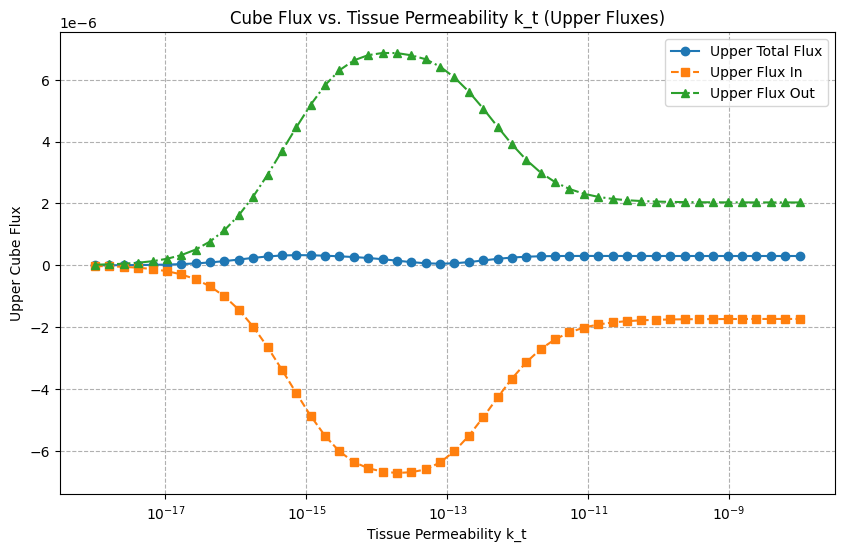

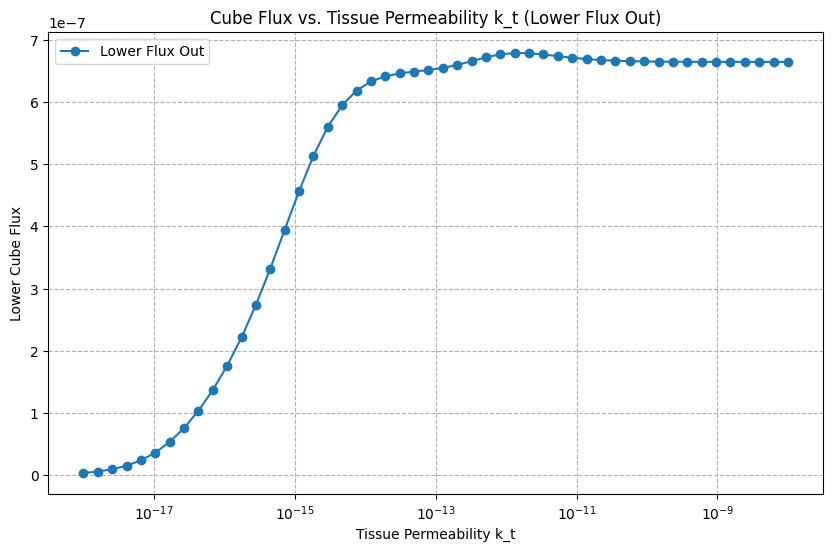

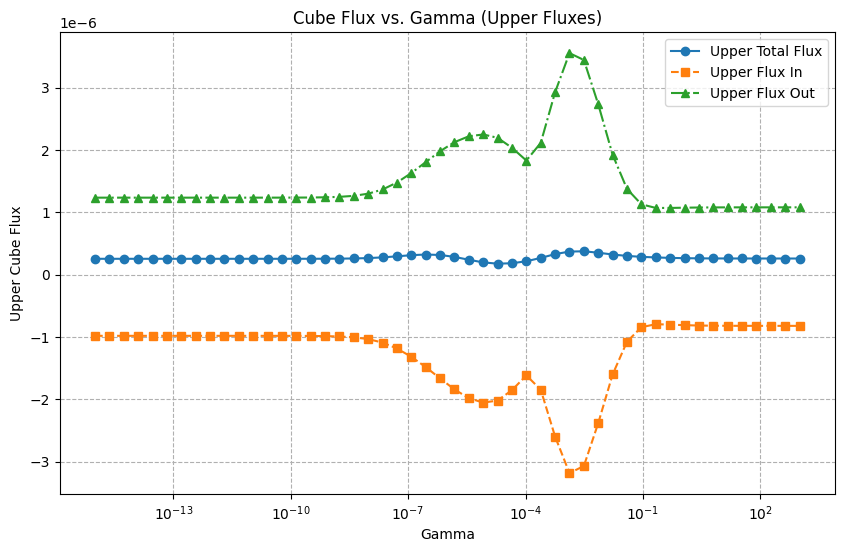

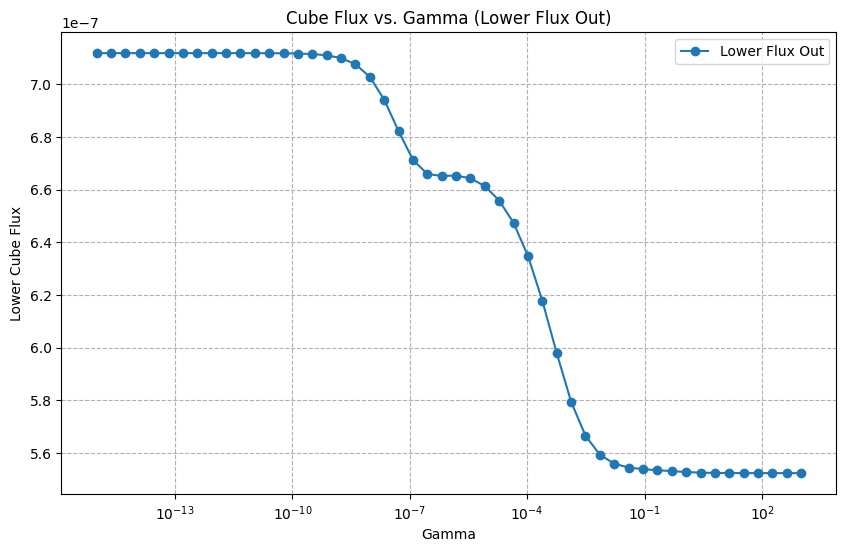

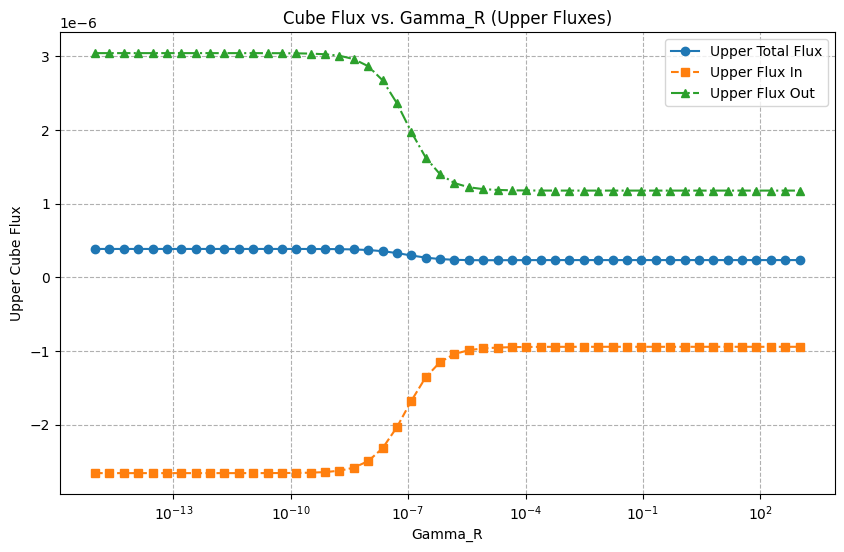

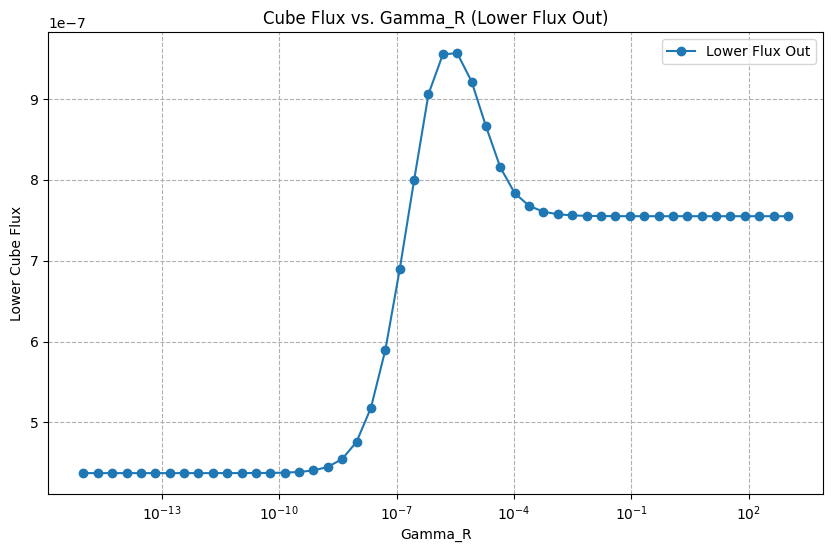

Data saved to ./export/output_sweeps_20250323_1335/sweep_results.csv


In [12]:
df_results, sweep_configs = perform_all_sweeps(num_points=50)
plot_results(df_results, sweep_configs, output_dir)
save_data_to_csv(df_results, output_dir)